## Import libraries

In [6]:
import os

import copick
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

## Load data

In [7]:
copick_filepath = "/home/michele/DNN/kaggle/kaggle_cryo_et/dataset/train/copick.config"
numpy_anns_dir = "/home/michele/DNN/kaggle/kaggle_cryo_et/dataset/train/numpy"
experiments_dir = "/home/michele/DNN/kaggle/kaggle_cryo_et/dataset/train/static/ExperimentRuns"
voxel_spacing = 10
tomo_type = "denoised"
available_runs = os.listdir(experiments_dir)
print(f"Available runs: {available_runs}")
root_copick = copick.from_file(copick_filepath)

Available runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']


### Select data

In [8]:
experiment_to_show = "TS_5_4"
experiment_ann = np.load(os.path.join(numpy_anns_dir, experiment_to_show + ".npy"))

## Visualize data

In [9]:
# Visualization as voxels is too slow

#ax = plt.figure().add_subplot(projection='3d')
#for obj in root_copick.pickable_objects:
#    if not obj.is_particle:
#        continue
#    print(f"Name: {obj.name}, radius: {obj.radius}, color: {obj.color}")
#    # Set color corresponding to label
#    particle_type_bool = experiment_ann == obj.label
#    ax.voxels(filled=particle_type_bool, facecolors=list(obj.color[:3]))
#ax.set_aspect('equal')
#plt.show()

### Draw centroids

CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7fa76eda3400
Name: apo-ferritin, radius: 60.0, color: (0, 117, 220, 128)
Name: beta-amylase, radius: 65.0, color: (153, 63, 0, 128)
Name: beta-galactosidase, radius: 90.0, color: (76, 0, 92, 128)
Name: ribosome, radius: 150.0, color: (0, 92, 49, 128)
Name: thyroglobulin, radius: 130.0, color: (43, 206, 72, 128)
Name: virus-like-particle, radius: 135.0, color: (255, 204, 153, 128)


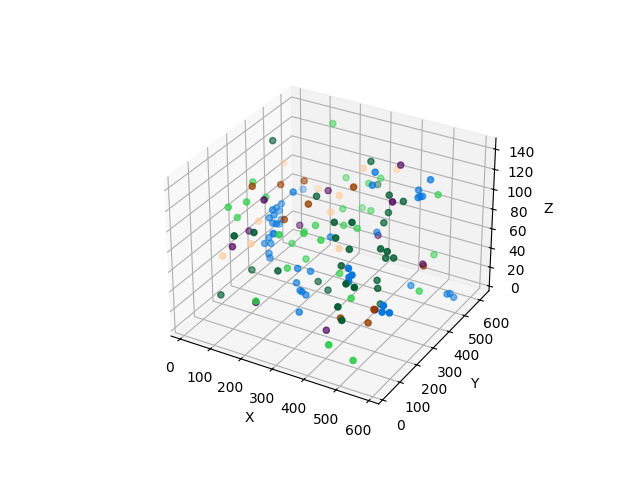

In [10]:
run = next(iter([single_run for single_run in root_copick.runs if single_run.name == experiment_to_show]))
print(run)

ax = plt.figure().add_subplot(projection='3d')
xs = []
ys = []
zs = []
colors = []
for obj in root_copick.pickable_objects:
    if not obj.is_particle:
        continue
    print(f"Name: {obj.name}, radius: {obj.radius}, color: {obj.color}")
    picks = run.get_picks(obj.name, user_id="curation", session_id="0")
    assert len(picks) == 1
    # Visualize each annotation independently
    for point in picks[0].points:
        # Center
        xs.append(round(point.location.x / voxel_spacing))
        ys.append(round(point.location.y / voxel_spacing))
        zs.append(round(point.location.z / voxel_spacing))
        colors.append(np.array(obj.color[:3]) / 255)
ax.scatter(xs, ys, zs, c=colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()